# Final Report and Summary of Analysis

### CONTENTS
    1. Purpose
    2. Data
    3. EDA
    4. Modeling
    5. Post-Modeling EDA
    6. Conclusions
    7. Recommendations
    8. Next Steps

In [19]:
# Imports
import os
import sys

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

#from sklearn.linear_model import LinearRegression
#import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
#import xgboost as xgb 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance

from itertools import islice

In [217]:
# Functions
def compute_seasons_left():
    """This is a function that computes our target variable, the number of seasons
    a player has left in their career. 
    """
    # Creating a 'seasons left' column with a placeholder value of -1.
    df['seasons_left'] = -1
    
    for player in df.Player.unique():
        # Creating a subsetted dataframe for each player
        temp_df = df[df.Player == player]
        # Gets the amount of seasons each player has played
        max_value = temp_df.season.max()
        # Appends the number of seasons left from the temp_df into main df
        for row in temp_df.index:
            df.loc[row, 'seasons_left'] = max_value - df.loc[row, 'season']
                    
def grab_by_element(df,target_column,elem):
    """
    Arguments:  df, target_column, elem
    Returns the dataframe compose of those rows in the original dataframe "df" that have "elem" as an element of their entry
    for column "target_column"
    """
    return df.loc[df[target_column].apply(lambda x: elem in x)]

def scatter_seasons(player = None, df = None):
    """Takes in a current NBA player's name, and returns a scatter plot of predicted career length
 for the years they have been in the NBA.
 
 Player - str, the name of the player
 df - obj, the dataframe in which the player is
     Retired players = pred_df
     Current Players = cp_df
    """
    sns.scatterplot(x='season', y='predictions', data=df.loc[df.Player == f'{player}'])
    plt.title(f'Seasons Played v Predicted for {player}')
    plt.xlabel('Current Season in NBA')
    plt.ylabel('Predicted Additional Seasons')
    plt.tight_layout()
    plt.show()
    return

def scatter_error(player = None, df = None):
    """Takes in a current NBA player's name, and returns a scatter plot of predicted career length
 for the years they have been in the NBA.
 
 Player - str, the name of the player
 df - obj, the dataframe in which the player is
     Retired players = pred_df
     Current Players = cp_df
    """
    # Creating a subsetted dataframe for player
    temp_df = df[df.Player == player]
    # Gets the amount of seasons each player has played
    max_value = temp_df.season.max()
    
    
    sns.scatterplot(x='season', y='error', data=temp_df)
    plt.hlines(0, xmin=1, xmax=max_value,
          linestyles='dashed', color='red')
    plt.title(f'Seasons Played v Predicted for {player}')
    plt.xlabel('Current Season in NBA')
    plt.ylabel('Error in Prediction')
    #plt.tight_layout()
    plt.show()
    return

def take(n, iterable):
    "Return first n items of the iterable as a dictionary."
    return dict(islice(iterable, n))

# 1. Purpose

Each year in the NBA, there are roughly 450 individual players. Only two or three per team being what most would consider to be "star players," and they are the ones that tend to be offered the most years in their contracts. Contracts typically range from 1-4 years, and they often end up being offered contracts in the 3-4 year range. This offers them security-- both financially, and in the peace of mind knowing where their families will be living for the next three to five years. 

That implies that the other ~83% of the players in the league are what would be considered "role players." They are not necessarily afforded the same financial security and peace of mind because they are often signed to 1-2 year contracts.

Using standard and advanced metrics, I'm creating a metric to estimate the number of years/seasons a player may have left in the NBA in an effort to help in the negotiation of longer contracts.

# 2. Data

Descriptions of the features used can be found in the data folder, under glossary.txt.

In order to best estimate the number of seasons left for any given player, I decided to focus on player production stats from https://www.basketball-reference.com/, and player characteristics such as Age, Height, and Weight that I downloaded from a pre-existing dataset on Kaggle (https://www.kaggle.com/justinas/nba-height-and-weight-analysis/notebook). These metrics were chosen with the idea that a model could learn to compare production-related stats across similar players and different years, and accurately predict a player's career length. 

Each row of data represents a single season for the given player.



#### Some basic data cleaning done to our initial frames:
- Some players were traded during the middle of a season, and as such will have 3+ rows. The first will be a player's total stats for the season (df.Tm == TOT), and the following will be stats for each of the teams the player recorded stats for, and subsequently drop them from the dataframe. 
- Dropping leftover rows that served as headers on the original document.
- Removing the '\*' denoting any player that has made the Hall of Fame (sorry y\'all).
- Removing any unnecessary instances of 'Unnamed: 0' columns.
- Created a "current_year" column for tracking the number of seasons a player has played.
- Created a "seasons_left" column for retired players.



#### Importing Data

In [46]:
df = pd.read_csv('data/final/final_df.csv')
df = df.drop(columns='Unnamed: 0')

df.shape

(9887, 149)

# EDA
A few things that I feel are going to be important in estimating career length are: Age, Weight, and Height. Let's take a look at the averages of each over the range of seasons in the data.

In [7]:
# Converting current_year to a string so the grab_by_element function will play nice.
df.current_year = df.current_year.astype(str)

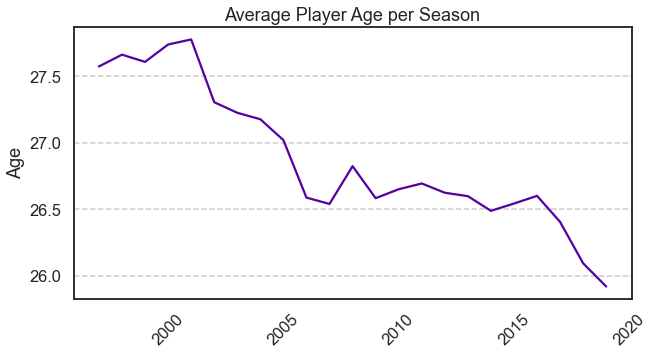

In [8]:
data_for_chart={}
for year in range(1997, 2020):
    data_for_chart[year]=grab_by_element(df,'current_year',str(year)).Age.mean()
  
global_context='talk'
fs=1.0

sns.set(global_context,font_scale=fs)
sns.set_style('white')
sns.set_palette('plasma')
plt.figure(figsize=(10,5))

ax=sns.lineplot(x=list(data_for_chart.keys()),y=list(data_for_chart.values()),color=sns.color_palette('plasma')[0])


ax.set(ylabel='Age')
ax.set(xlabel='');
ax.xaxis.grid(False)
ax.yaxis.grid(True)
ax.axes.grid(axis='y',linestyle='--')
ylabels=[f'{float(s)}' for s in ax.get_yticks()]
ax.set_yticklabels(ylabels)

plt.xticks(rotation=45)

plt.title(f'Average Player Age per Season')
plt.show()

    The average age of players per season appears to have been on a constant decline since around 2000. It doesn't come as too much of a surprise as players are being asked to be able to do more things for their teams, and younger, more athletic players, tend to be able to fit into that mold.

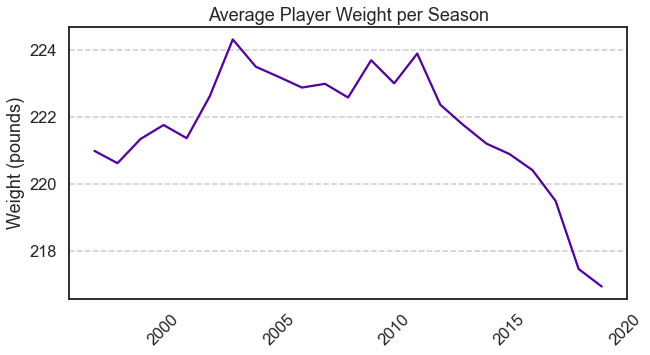

In [72]:
data_for_chart={}
for year in range(1997, 2020):
    data_for_chart[year]=grab_by_element(df,'current_year',str(year)).player_weight.mean()
  
global_context='talk'
fs=1.0

sns.set(global_context,font_scale=fs)
sns.set_style('white')
sns.set_palette('plasma')
plt.figure(figsize=(10,5))

ax=sns.lineplot(x=list(data_for_chart.keys()),y=list(data_for_chart.values()),color=sns.color_palette('plasma')[0])


ax.set(ylabel='Weight (pounds)')
ax.set(xlabel='');
ax.xaxis.grid(False)
ax.yaxis.grid(True)
ax.axes.grid(axis='y',linestyle='--')
ylabels=[f'{int(s)}' for s in ax.get_yticks()]
ax.set_yticklabels(ylabels)

plt.xticks(rotation=45)

plt.title(f'Average Player Weight per Season')
plt.show()

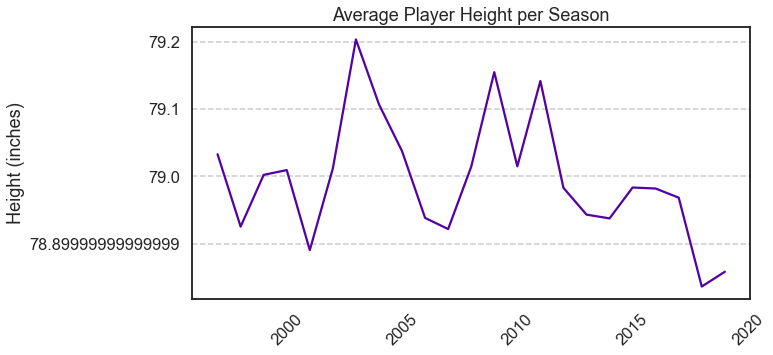

In [74]:
data_for_chart={}
for year in range(1997, 2020):
    data_for_chart[year]=grab_by_element(df,'current_year',str(year)).player_height.mean()
  
global_context='talk'
fs=1.0

sns.set(global_context,font_scale=fs)
sns.set_style('white')
sns.set_palette('plasma')
plt.figure(figsize=(10,5))

ax=sns.lineplot(x=list(data_for_chart.keys()),y=list(data_for_chart.values()),color=sns.color_palette('plasma')[0])


ax.set(ylabel='Height (inches)')
ax.set(xlabel='');
ax.xaxis.grid(False)
ax.yaxis.grid(True)
ax.axes.grid(axis='y',linestyle='--')
ylabels=[f'{float(s)}' for s in ax.get_yticks()]
ax.set_yticklabels(ylabels)

plt.xticks(rotation=45)

plt.title(f'Average Player Height per Season')
plt.show()

    The average weight and height visuals speak to the trends that have been observed in the NBA over the past 20 years. Both show a spike shortly after the 1999-00 season in response to the dominance of big men like David Robinson and Tim Duncan on the Spurs in '99, and Shaq on the early-2000's Lakers. 

    These spikes are followed up by drops in value in the mid-2000's as players like Dwyane Wade and Manu Ginóbili rose to prominence, while battling more defensive teams such as the Pistons and Spurs.

    Reaching 2010, the averages shot up again momentarily, likely to try counteracting the '08 Celtics, and '08-10 Lakers. Finally, the averages begin to drop off indicating the change in playstyle towards "small ball," started by the Heat and Spurs, and perfected by the Warriors.

# 4. Modeling
##### Post-MVP, I will be checking for the assumptions of linearity required for running a standard linear regression model.

I've decided to run a number of regression models that can predict our quantitative target variable. After looking at the results from these vanilla models, I will then tune the most promising models based off of their RMSE.

The models to be ran are:
1. KNN Regressor (KNN)
2. Decision Tree Classifier (DT)
3. Random Forest Regressor (RF)
4. Extra Trees Regressor (ET)
5. AdaBoost (ADA)
6. Naive Bayes Gaussian (Gaussian)


As of right now, I don't have the year undrafted players played their first game. As this information is key in predicting their number of seasons left, I have to drop them from the dataframe.

Also, players who are currently playing in the NBA will be dropped for the purposes of modeling, as they have no year of retirement to calculate a number of seasons left; however, I will save them to a dataframe for post-modeling EDA.

We're going to lose a third of our entries. It's not ideal, but it's necessary for the moment.

In [47]:
# Re-converting current_year to an integer for the modeling portion.
df.current_year = df.current_year.astype(int)

current_players = list(df[df.current_year == 2019].Player)
cp_df = df[df.Player.isin(current_players)]

df = df[~df.Player.isin(current_players)]
df = df[df.drafted == 1]
df.shape

(6017, 149)

##### Creating the target variable of "seasons_left" by creating a variable "season" to track each player's current year in the NBA, and then taking the max value from that column and subtracting their current season from that max value.

In [48]:
df['season'] = df.current_year - df.draft_year

compute_seasons_left()

df.shape

(6017, 151)

##### Currently dropping player position from the features. Will be clustering to include positions for a post-MVP product.

In [83]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
import xgboost as xgb 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

# Models to be ran, in the format {'Abbreviation' : Instantiated Model}
models = {'KNN': KNeighborsRegressor(),
          'DT': DecisionTreeRegressor(),
          'RF': RandomForestRegressor(),
          'ET': ExtraTreesRegressor(),
          'ADA': AdaBoostRegressor(),
          'Gaussian': GaussianNB(),
          }

# Dropping our target variable and categorical variables our X data.
X = df.drop(columns = ['Pos', 'Tm'])
# Setting our target variable to y.
y = df[['seasons_left']]
# Splitting our data into train and test sets
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=98)

# Flattening the target variables to a 1d array for our models
y_train = y_train.seasons_left.values.ravel()
y_test = y_test.seasons_left.values.ravel()
y = y.seasons_left.values.ravel()

# Testing each model
results = []
model_names = []
pbar = tqdm(models.items())

for model, m in pbar: 
    # Fitting our models to the training data
    m.fit(X_train.drop(columns=['Player', 'seasons_left']), y_train)
    # Setting a progress bar to track the progress of each model
    pbar.set_description(f'Evaluating {model.upper()}')
    # Predicting target variables
    train_pred = m.predict(X_train.drop(columns=['Player', 'seasons_left']))
    # Saving our R^2 values
    scores = m.score(X_train.drop(columns=['Player', 'seasons_left']), y_train)
    # Saving our Root Squared Mean Errors
    rmses = np.sqrt(mean_squared_error(y_train, train_pred))
    
    results.append((scores, rmses))
    model_names.append(model)   
    
# Printing out the results of our models
vanilla_dict = {i:y for i,y in zip(model_names, results)}
vanilla_dict

Evaluating GAUSSIAN: 100%|██████████| 6/6 [00:27<00:00,  4.62s/it]


{'KNN': (0.43907143604076204, 2.7934951599760245),
 'DT': (1.0, 0.0),
 'RF': (0.9448380802956898, 0.8760196160783157),
 'ET': (1.0, 0.0),
 'ADA': (0.47405987172350716, 2.704969043178243),
 'Gaussian': (0.21774361105339704, 4.1363374314445345)}

From the baseline models, three are immediately out of interest: DT and ET as they are overfitting to the point of having a RMSE of 0 years, and the Gaussian model because the RMSE is far higher than the others, with no opportunities for hypter tuning.

That leaves us with the following models to hypertune: 
1. KNN
2. ADA
3. RF 

RF is likely also overfitting in its vanilla state, but with some hyptertuning I believe it'll end up in a more accurate state.

For the initial MVP, I will be using a Randomized Grid Search in the interest of time.

#### KNNRegressor Tuning
For the KNN, I've chosen to search through 30 neighbors. Initially, I tried a neighbor range of 1-90 as there are ~450 players each season, and traditional 5 positions (450/5 = 90). The param search returned 20 neighbors as being the best, and so I lowered it to a range of 1-30 to re-test, and returned the same results.

In [23]:
# Setting the parameters to be searched through.
k_range = list(range(1, 30))

param_grid = {
    'n_neighbors': k_range,
    'p': [1, 2],
}

gs = RandomizedSearchCV(estimator = KNeighborsRegressor(), param_distributions = param_grid,
                        n_jobs = -1, verbose = 1, n_iter = 50)

gs.fit(X_train.drop(columns = ['Player', 'seasons_left']), y_train)

print(f'KNN\'s Best Estimators')
print(gs.best_estimator_)
print('\n')

KNN_tuned = gs.best_estimator_

# Printing R^2 and RMSE for the KNN Regressor
train_pred = KNN_tuned.predict(X_train.drop(columns = ['Player', 'seasons_left']))
test_pred = KNN_tuned.predict(X_test)

print(f'Train Set R^2: {KNN_tuned.score(X_train.drop(columns = ['Player', 'seasons_left']), y_train)}')
print(f'Train Set RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}')
print('\n')
print(f'Test Set R^2: {KNN_tuned.score(X_test.drop(columns = ['Player', 'seasons_left']), test_pred)}')
print(f'Test Set RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}')

# Vanilla Results
#'KNN': (0.43907143604076204, 2.7934951599760245)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    6.7s finished


KNN's Best Estimators
KNeighborsRegressor(n_neighbors=20, p=1)


Train Set R^2: 0.3818174084719619
Train Set RMSE: 2.9325979771341615


Test Set R^2: 1.0
Test Set RMSE: 3.062268365367124


#### KNN Results
The training set is underfitting with the model, and the test set is overfitting. Both end up producing an error of about 3 years. However, the train set predictions are worse than the default settings ran in the earlier vanilla test. I'd like to get it closer to the 1-2 year range, as that range is equal to that of a typical contract for role players.

With the training set underfitting the way it is, I will move on to checking out a tuned version of the second of three chosen vanilla models, the AdaBoost.

#### AdaBoost Tuning
For choosing parameter values, I chose values close to, and on either side of the default values.

In [25]:
#AdaBoost Tuning
AdaBoostRegressor()
#Setting the parameters to be searched through
param_grid = {
            'n_estimators': [10, 25, 50, 75],
            'learning_rate': [0.25, 0.5, 1, 1.25, 1.5],
            'loss': ['linear', 'square'],
            'random_state': [98]
        }

gs = RandomizedSearchCV(estimator = AdaBoostRegressor(), param_distributions = param_grid,
                        n_jobs = -1, verbose = 1, n_iter = 50)

gs.fit(X_train.drop(columns = ['Player', 'seasons_left']), y_train)

print(f'AdaBoost\'s Best Estimators')
print(gs.best_estimator_)
print('\n')

ADA_tuned = gs.best_estimator_

train_pred = ADA_tuned.predict(X_train.drop(columns = ['Player', 'seasons_left']))

# Printing R^2 and RMSE for the AdaBoost
test_pred = ADA_tuned.predict(X_test)

print(f'Train Set R^2: {ADA_tuned.score(X_train.drop(columns = ['Player', 'seasons_left']), y_train)}')
print(f'Train Set RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}')
print('\n')
print(f'Test Set R^2: {ADA_tuned.score(X_test.drop(columns = ['Player', 'seasons_left']), test_pred)}')
print(f'Test Set RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}')

# Vanilla Results
# 'ADA': (0.4269527347343016, 2.8235102417133247)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/npardue/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished


AdaBoost's Best Estimators
AdaBoostRegressor(learning_rate=0.5, n_estimators=25, random_state=98)


Train Set R^2: 0.5234762006588052
Train Set RMSE: 2.574758159568542


Test Set R^2: 1.0
Test Set RMSE: 2.608009365301043


#### AdaBoost Results
The model is better fit to the training data than the KNN, and also has improved upon its predictions post-tuning. The test set is again overfit. 
Since the train set R^2 value is still fairly underfit, I still want to look at a tuned version of the third and final model from the vanilla models-- the Random Forest.

#### Random Forest Tuning
For choosing parameter values, I chose to and on either side of the default values.

In [84]:
# RandomForest Tuning
param_grid = {
            'n_estimators': [25, 50, 75, 100],
            'criterion': ['mse'],
            'max_depth': [None, 100, 250, 300, 350, 450],
            'min_samples_split': [5, 8, 10, 15],
            'min_samples_leaf': [3, 5, 10, 15],
            'max_features': [10, 15, 20, 25, 30],
        }

# In the interest of time, going to be using RandomizedSearchCV over GridSearch.
gs = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = param_grid,
                                verbose = 1, n_iter = 50,
                                n_jobs = -1)

gs.fit(X_train.drop(columns=['Player', 'seasons_left']), y_train)

print(f'Random Forest\'s Best Estimators')
print(gs.best_estimator_)
print('\n')

RF_tuned = gs.best_estimator_


# Vanilla Results
#'RF': (0.9461559416241221, 0.8654919612141071)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.0min finished


Random Forest's Best Estimators
RandomForestRegressor(max_depth=250, max_features=30, min_samples_leaf=5,
                      min_samples_split=10)




In [85]:
# Printing R^2 and RMSE for the Random Forest Regressor
train_pred = RF_tuned.predict(X_train.drop(columns = ['Player', 'seasons_left']))
test_pred = RF_tuned.predict(X_test.drop(columns = ['Player', 'seasons_left']))

print(f'Train Set R^2: {RF_tuned.score(X_train.drop(columns = ["Player", "seasons_left"]), y_train)}')
print(f'Train Set RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}')
print('\n')
print(f'Test Set R^2: {RF_tuned.score(X_test.drop(columns = ["Player", "seasons_left"]), test_pred)}')
print(f'Test Set RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}')


Train Set R^2: 0.8446162595455569
Train Set RMSE: 1.4702694424547553


Test Set R^2: 1.0
Test Set RMSE: 2.3323885540349574


#### Random Forest Results
Wow! The RF on average predicts within 1.47 years of actual career length on the training set, and within 2.4 years on the test set. However afraid I am that they may still be overfitting to both datasets, I will further address that in the time post-MVP. 

(I did some further manual RF tuning in the ModelingMoreFeats notebook, but no improvements were made with regards to the overfitting).

#### Visualizing RF Results

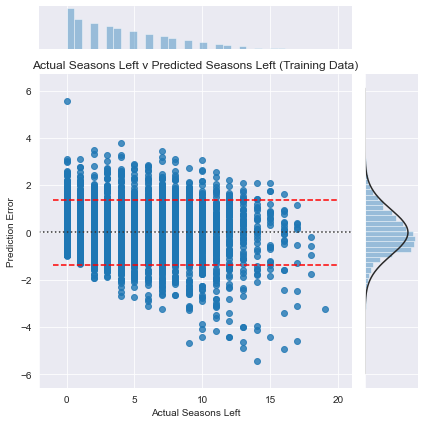

In [31]:
# Doing a jointplot with the residuals of our data to see how far off our estimations are.
sns.jointplot(y_train, train_pred, kind = 'resid')


#Plotting lines that indicate where our RMSE lies.
plt.hlines(np.sqrt(mean_squared_error(y_train, train_pred)), xmin=-1, xmax=20,
          linestyles='dashed', color='red')
plt.hlines(-(np.sqrt(mean_squared_error(y_train, train_pred))), xmin=-1, xmax=20,
          linestyles='dashed', color='red')

plt.xlabel('Actual Seasons Left')
plt.ylabel('Prediction Error')
plt.title('Actual Seasons Left v Predicted Seasons Left (Training Data)')
plt.tight_layout()
plt.show()

    On the training data model seems to have trouble with predicting the outliers of players that played 9+ seasons, and is more accurate in predicting additional career length of players in the 0-5 season range.

In [46]:
print(f'Train Career Length Data- \nAvg: {y_train.mean()}, StDev: {y_train.std()}')

Train Career Length Data- 
Avg: 4.1793060461250775, StDev: 3.729873864450513


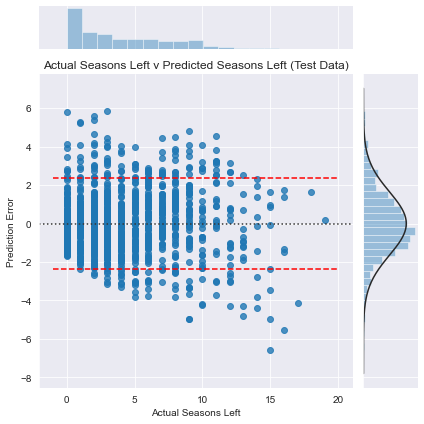

In [32]:
# Doing a jointplot with the residuals of our data to see how far off our estimations are.
sns.jointplot(y_test, test_pred, kind = 'resid')


#Plotting lines that indicate where our RMSE lies.
plt.hlines(np.sqrt(mean_squared_error(y_test, test_pred)), xmin=-1, xmax=20,
          linestyles='dashed', color='red')
plt.hlines(-(np.sqrt(mean_squared_error(y_test, test_pred))), xmin=-1, xmax=20,
          linestyles='dashed', color='red')

plt.xlabel('Actual Seasons Left')
plt.ylabel('Prediction Error')
plt.title('Actual Seasons Left v Predicted Seasons Left (Test Data)')
plt.tight_layout()
plt.show()

    Again, on the test data, the model seems to have a harder time estimating career length for players whose career length would be considered outliers, and gets better as it approaches the average range of players in the 0-5 year range. 

In [45]:
print(f'Test Career Length Data- \nAvg: {y_test.mean()}, StDev: {y_test.std()}')

Test Career Length Data- 
Avg: 4.1993355481727574, StDev: 3.7106920431238213


After looking at the results, I have to ask..

### Which features are important?

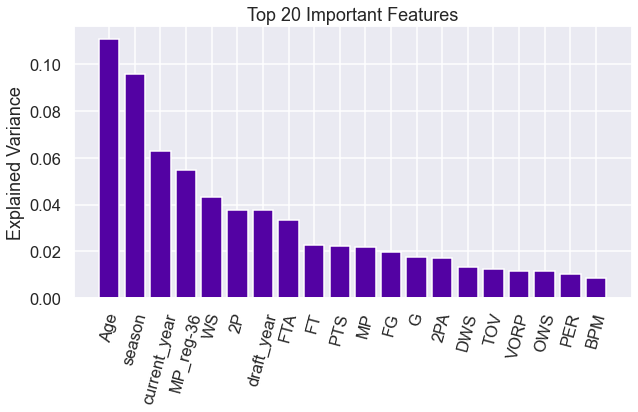

In [23]:
important_features_dict = {}

for x,i in enumerate(RF_tuned.feature_importances_):
    important_features_dict[list(X.columns)[x]]=i

importance_dict = sorted(important_features_dict.items(), key=lambda x: x[1], reverse=True)

# plot feature importance
plt.figure(figsize = (10, 5))
plt.bar(take(20, importance_dict).keys(), take(20, importance_dict).values())

plt.xticks(rotation=75)
plt.ylabel('Explained Variance')
plt.title('Top 20 Important Features')
plt.show()

A product of introducing too many variables into the model, only 4 of the 147 features offer over 5% reduction in error on average across the individual trees.

Perhaps unsurprisingly, many of the features are relating to a player's age (Age, season, current_year, draft_year). Also, there are a few relating to amount someone play each season (G/GamesPlayed & GS/Games Started, MP/Minutes Played), which isn't very enlightening. The other features are production stats, and win shares (an estimate of # of wins a player contributed due to their offense and/or defense). 

Another thing to check out is the permutation importance of each feature. Essentially, this is how much more inaccuracy the predictions would be if X feature was removed.


In [22]:
#Code from: https://scikit-learn.org/stable/modules/permutation_importance.html
r = permutation_importance(RF_tuned, X_test, y_test,
                           n_repeats=30,
                           n_jobs = -1,
                           random_state=98)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_test.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Age     0.146 +/- 0.010
season  0.130 +/- 0.009
current_year0.081 +/- 0.009
draft_year0.027 +/- 0.003
MP_reg-360.017 +/- 0.004
WS      0.014 +/- 0.004
MP      0.009 +/- 0.001
2P      0.008 +/- 0.002
G       0.008 +/- 0.002
FTA     0.006 +/- 0.001
PTS     0.006 +/- 0.001
FG      0.005 +/- 0.001
2PA     0.005 +/- 0.001
DWS     0.005 +/- 0.001
current_year_playoffs0.004 +/- 0.001
FT      0.004 +/- 0.001
TOV     0.003 +/- 0.001
OWS     0.003 +/- 0.001
BPM     0.002 +/- 0.001
TRB     0.002 +/- 0.000
PF      0.002 +/- 0.001
ORB     0.002 +/- 0.001
ORB%    0.002 +/- 0.000
BLK_reg-advanced0.002 +/- 0.000
FT_reg-advanced0.002 +/- 0.001
TOV%    0.001 +/- 0.001
FT%_reg-advanced0.001 +/- 0.000
DRB     0.001 +/- 0.000
player_height0.001 +/- 0.000
FT%     0.001 +/- 0.000
TOV_reg-advanced0.001 +/- 0.000
player_weight0.001 +/- 0.000
2PA_playoffs0.001 +/- 0.000
3PA     0.001 +/- 0.000
2P_play-advanced0.000 +/- 0.000
3P_playoffs0.000 +/- 0.000
FG%_playoffs0.000 +/- 0.000


The permutation importance seems to follow the same trend as the above feature importance, in that features relating to a player's age have the most impact on the predictions, with features relating to offensive production following behind ('2P' field goals attempted, Free Throws attempted, points scored, overall field goals attempted), with amount of time played each season and amount of wins contributed to the team also among the top spots.

# 5. Post-Modeling EDA
As of the end of the 2018-19 season, two players come to mind that are not included in the model, as they have both retired by the end of the 2020 season. They're Dirk Nowitzki and Vince Carter. What would the model's predictions of their careers, and their time as role players look like? 

In [144]:
# Performing the same basic cleaning steps done to the main dataframe. 
cp_df['season'] = cp_df.current_year - cp_df.draft_year
cp_df = cp_df.loc[cp_df.drafted==1]
cp_df = cp_df.drop(columns = ['Pos', 'Tm'])
cp_df

pred_cp = RF_tuned.predict(cp_df.drop(columns ='Player'))

# Setting our predictions to a dataframe
pred_cp = pd.DataFrame(pred_cp)
# Matching the predictions' indexes to those of the current players.
pred_cp.index = cp_df.index

# Merging predictions onto the dataframe
cp_df = cp_df.merge(pred_cp, left_index=True, right_index=True)
cp_df.rename(columns={0:'predictions'}, inplace=True)

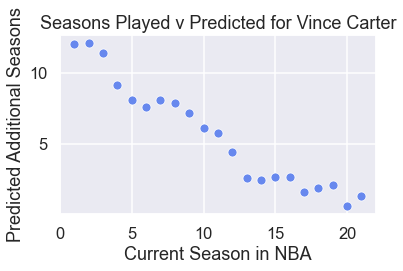

In [147]:
scatter_seasons('Vince Carter', cp_df)
# Played 21 seasons

For VC, the model produced a lot of error throughout most of his career. However, this may be more of a product of Carter's unparalleled ability to adapt his playstyle. 

In his first three years, he won Rookie of the Year, and in the subsequent two seasons was an All-Star and named to All-NBA teams. He was undoubtebly the superstar centerpiece of his team. The error for these three seasons was roughly an average of 8 seasons, and the major change in projection was likely a result of a knee injury that occured in his third season, and carried over into his 4th season.

Though injuries became a part of his career, he was still able to produce as a key piece of competitive teams. From season 4 through season 11, the model predicted he would likely play about 16 seasons, which average out to an error of 5 seasons per season. 

At season 12, there's another drop in projected seasons that estimates he'd play no more than 4 more seasons for the rest of his career; however, it hovers in the 2-4 estimated seasons range up until his 18th season(!) and has an average error of around 4 seasons per season. This trend is likely because of his willingness to accept a new role as a role player and mentor for younger players.

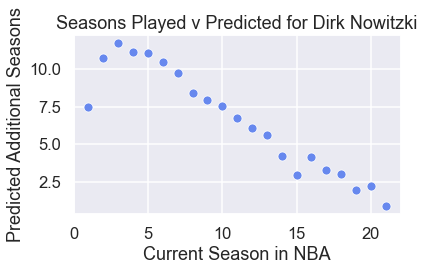

In [148]:
scatter_seasons('Dirk Nowitzki', cp_df)
# Played 21 seasons

For Dirk, the model predicted after his rookie season that he would play a total of 7 of his eventual 21 seasons. That's an error of 14 seasons! Major errors occured until around his 6th season, when it honed in on and followed a prediction pattern that he would play roughly 16-18 seasons, then predicting 20-21 seasons of play around the 17 season mark, and hit dead on that he had no full seasons left to play in his 21st season. 

### How does the model's prediction error shake out with players of varying career lengths?

What I want to do is take a closer look at predictions for all players who played 5 years, and all players who played at least 10 years. Afterwards, I'll look at the error in predictions for a single player that played 5 years in the NBA, and compare that to the error in Vince Carter's 21 years of predictions.

In order to do this, I'm going to merge the predictions onto the dataframe used in the modeling process, and then make an 'error' column. Also, as Carter is not currently listed as having retired for this particular dataset I'm going to repeat the same process for his entries in the current players dataframe.

In [ ]:
# Setting our predictions to a dataframe
test_pred_df = pd.DataFrame(test_pred)
train_pred_df = pd.DataFrame(train_pred)

# Matching the predictions' indexes to those of the retired players.
test_pred_df.index = X_test.index
train_pred_df.index = X_train.index

# Merging predictions onto the dataframes
train_df = X_train.merge(train_pred_df, left_index=True, right_index=True)
train_df.rename(columns={0:'predictions'}, inplace=True)

test_df = X_test.merge(test_pred_df, left_index=True, right_index=True)
test_df.rename(columns={0:'predictions'}, inplace=True)

pred_df = pd.concat([train_df, test_df], ignore_index=True).sort_values(by='current_year', ascending=True)

pred_df['error'] = pred_df.predictions - pred_df.seasons_left

# Repeating essentially the same steps for Vince Carter
VC_df = cp_df[cp_df.Player == 'Vince Carter']
# Gets the amount of seasons played
max_value = VC_df.season.max()
VC_df['seasons_left'] = -1
VC_df['seasons_left'] = max_value - VC_df.season
# Appends the number of seasons left from the temp_df into main df
for row in VC_df.index:
    df.loc[row, 'seasons_left'] = max_value - VC_df.loc[row, 'season']
    
VC_df['error'] = VC_df.predictions - VC_df.seasons_left

# These are lists of retired players, used to check error over the course of different 
# career lengths.
zero_to_five = list(pred_df[(pred_df.seasons_left == 0) & (pred_df.season <= 5)\
                        & (pred_df.current_year != 2019)].Player)

ten_plus = list(pred_df[(pred_df.seasons_left == 0) & (pred_df.season > 9)\
                        & (pred_df.season < 25) & (pred_df.current_year != 2019)].Player)

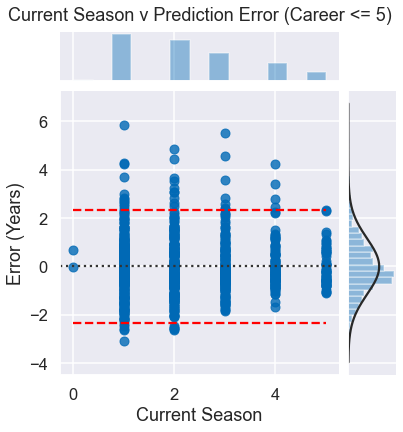

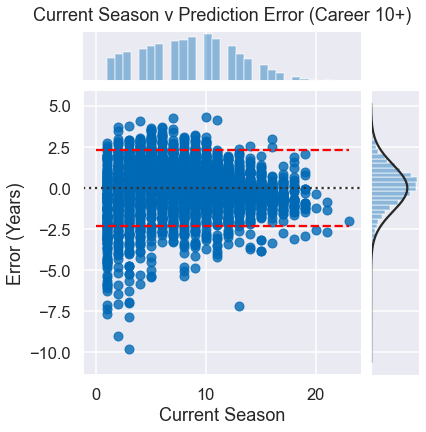

In [231]:
# Jointplot with the residuals of our data to see how far off our estimations are for
# players who played 0-5 seasons.
sns.jointplot('season', 'error', kind = 'resid', color='#0069b5',
             data = pred_df[pred_df.Player.isin(zero_to_five)])

#Plotting lines that indicate where our RMSE lies.
plt.hlines(np.sqrt(mean_squared_error(y_test, test_pred)), xmin=0, xmax=5,
          linestyles='dashed', color='red')
plt.hlines(-(np.sqrt(mean_squared_error(y_test, test_pred))), xmin=0, xmax=5,
          linestyles='dashed', color='red')

plt.xlabel('Current Season')
plt.ylabel('Error (Years)')
plt.title('Current Season v Prediction Error (Career <= 5)', pad=70,)
# plt.tight_layout()
plt.show()


# Jointplot with the residuals of our data to see how far off our estimations are for
# players who played 10 or more seasons.
sns.jointplot('season', 'error', kind = 'resid', color='#0069b5',
             data = pred_df[pred_df.Player.isin(ten_plus)])

#Plotting lines that indicate where our RMSE lies.
plt.hlines(np.sqrt(mean_squared_error(y_test, test_pred)), xmin=0, xmax=23,
          linestyles='dashed', color='red')
plt.hlines(-(np.sqrt(mean_squared_error(y_test, test_pred))), xmin=0, xmax=23,
          linestyles='dashed', color='red')

plt.xlabel('Current Season')
plt.ylabel('Error (Years)')
plt.title('Current Season v Prediction Error (Career 10+)', pad=70,)
# plt.tight_layout()
plt.show()



### Now to take a closer look a player from each of the two categories.

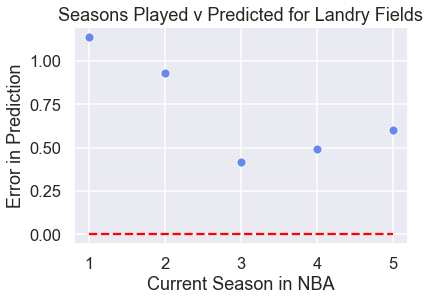

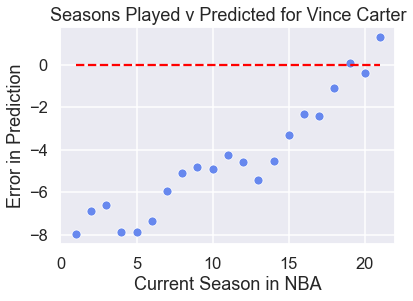

In [229]:
scatter_error('Landry Fields', pred_df)
scatter_error('Vince Carter', VC_df)

These examples reflect the earlier test data results that the model poorly predicts the early years of what are objectively long careers, and improves in predicting career length as the career length decreases (as Fields' predictions were constantly within .5 years and 1 year of the actual number of seasons played, and as Carter's predictions got progressively closer to perfect while approacing the end of his career).

I can't currently think of any ways of modeling to predict playstyle adaptation, and additional seasons brought on through a mentorship role. 

# 6. Conclusions

From the results of the final RF model, there are a couple things that come to mind. 
    1. There are a lot of outliers that affect the accuracy of the model.
    2. There may be too many features, leading to the overfitting issues.

To address these issues, I'd like to do two things:
    1. Gather more data!

The datasets used contain the either the entirity, or the majority careers of some of the greatest draft classes in NBA history (1984, 1985, 1987, 1996, 1998, 1999). Many of the players that were drafted in these years played for 15-20 seasons. To name just one from each, Hakeem Olajuwon (17), Karl Malone (18), Reggie Miller (18), Kobe Bryant (20), Dirk Nowitzki (21!), and Shawn Marion (16), respectively. With more data, these outliers and the many more introduced, would be counterbalanced by additional players who had career lengths closer to that of the average of 4.5 years 

    2. Reduce the number of features! 
Ideally, I'd rerun the model (post-MVP) with only those identified by the model to be important, and perhaps only use the production stats that are scaled up or down by a per-36 minutes measure (the avg. number of minutes a starter plays). This form of scaling would be useful in measuring what players are (theoretically) able to produce with the same amount of time spent on the court.

# 7. Recommendations

With this model, players and their agents can take the predicted additional seasons value into contract negotiations. As the average error in predictions was just over 2 years, that means a predicted value of 2 years would create an interval of 0-4 possible years left. Depending on the prediction, there are a few possible situations they may find themselves in: 


My suggestion for players with a predicted value of 2 or less would be to get ANY contract! These players are either on their way out, or maybe they shouldn’t have been here in the first place. Negotiate like your income depends on it. Maybe leverage some intagibles that you could bring to the team.

Next come players with predictions in the range of 3-5 years, and they should use the prediction to negotiate a contract that is at least 2 years.

Finally for players with predictions above 5 years, they likely won’t even bother with the model as teams are more likely to be chomping at the bit to sign them.




# 8. Next Steps
    1. Gather more data
    2. Reduce the number of features
    3. Find and include number of past injuries
    4. Include a feature of "player type" generated by clustering production
    stats, in lieu of using traditional positions